Iñigo Martin Melero

## Participante 29

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_29_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


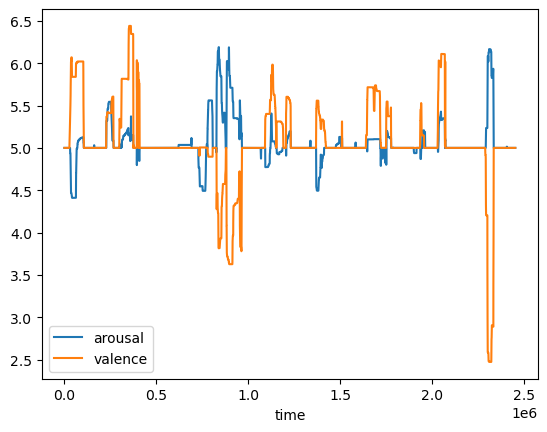

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_29_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.941  35.295  48.649  48.014  31.560     7.329     8.603   
1              1  0.941  35.392  48.562  48.024  31.553     7.329     8.562   
2              2  0.941  35.488  48.475  48.034  31.546     7.329     8.521   
3              3  0.941  35.585  48.388  48.043  31.539     7.329     8.479   
4              4  0.948  35.299  48.434  48.072  31.545     7.410     8.682   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.732  52.625  47.259  46.020  29.242     4.988     8.925   
2451580  2451580  0.728  52.848  47.346  46.020  29.242     4.988     8.966   
2451581  2451581  0.725  53.070  47.432  46.020  29.242     4.988     9.007   
2451582  2451582  0.722  53.293  47.519  46.020  29.242     4.988     9.048   
2451583  2451583  0.718  53.516  47.606  46.020  29.242     4.988     9.089   

         emg_trap  video  
0           7.945     10

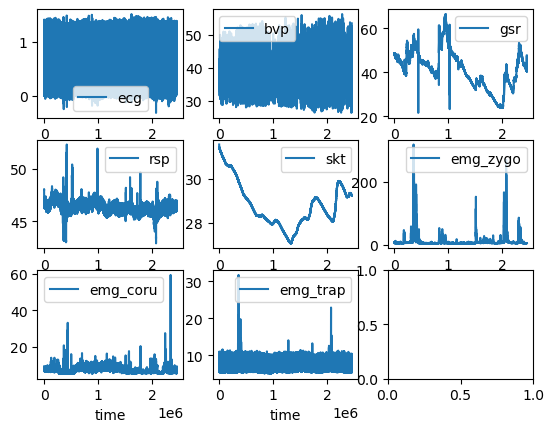

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

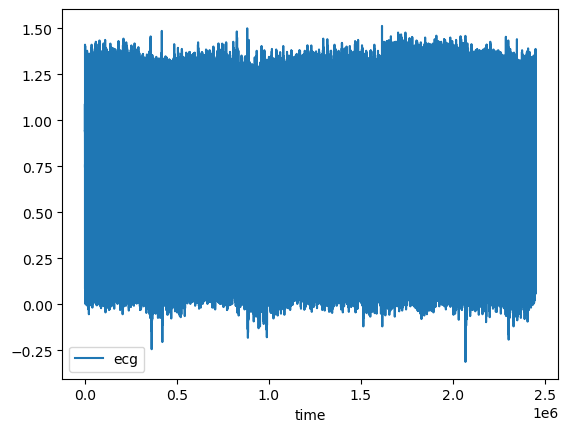

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

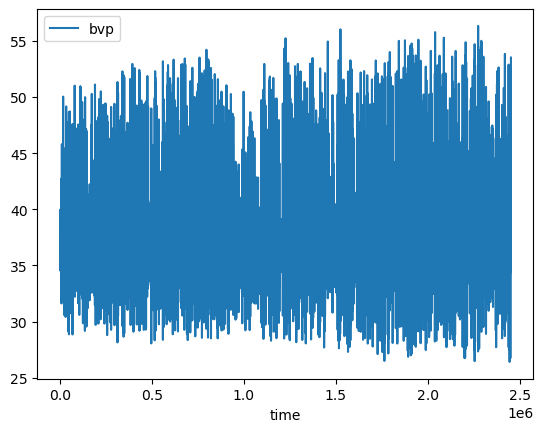

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

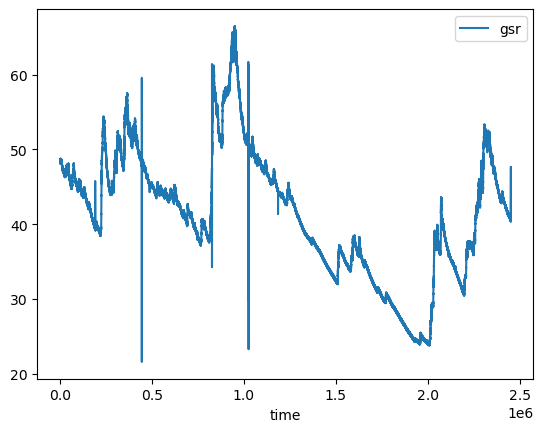

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

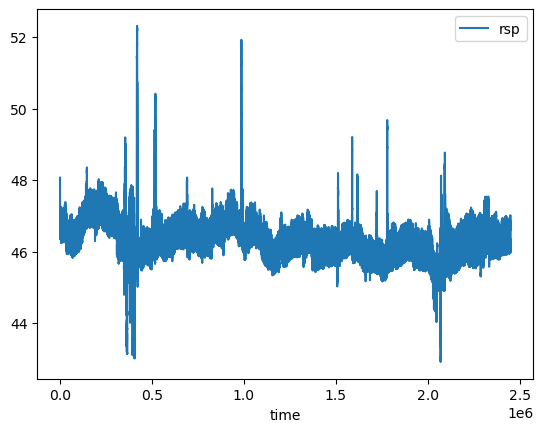

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

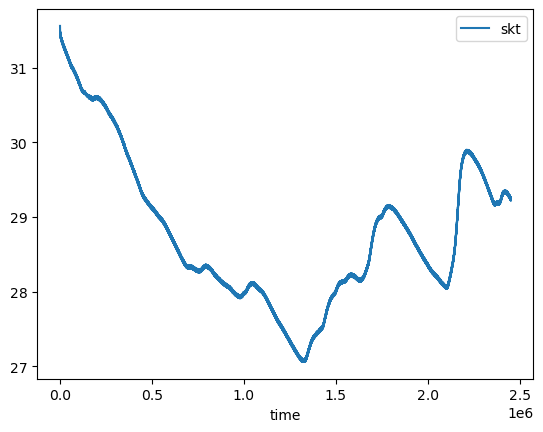

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

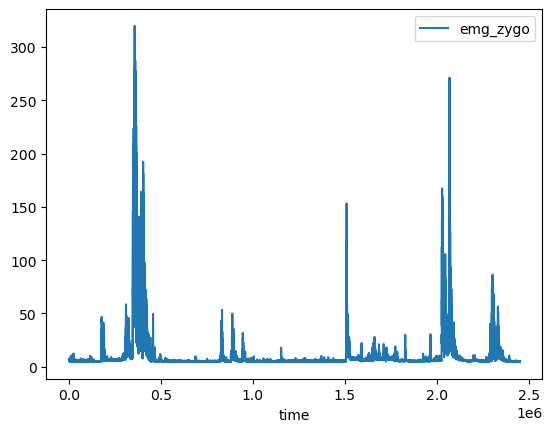

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

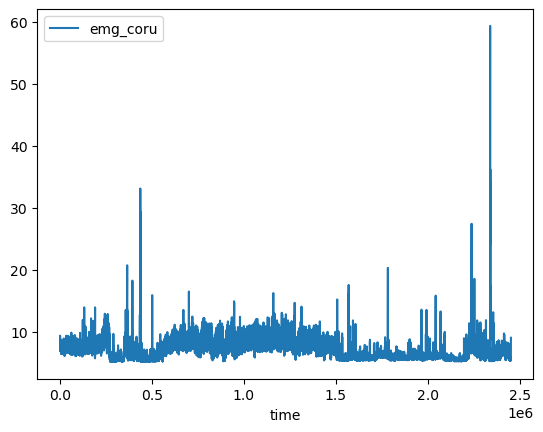

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

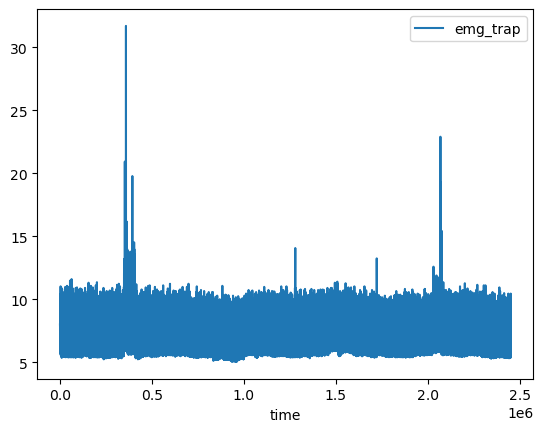

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

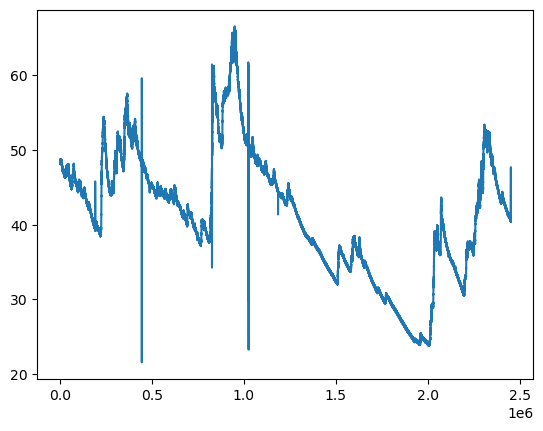

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

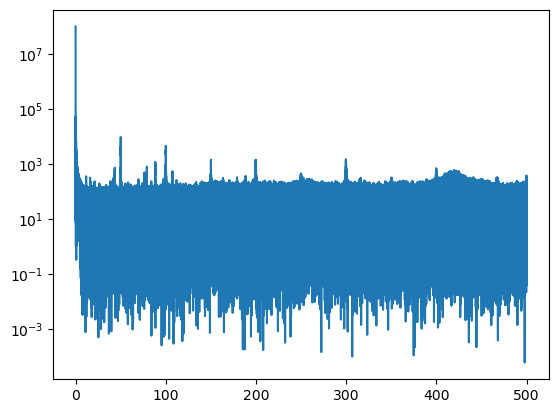

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

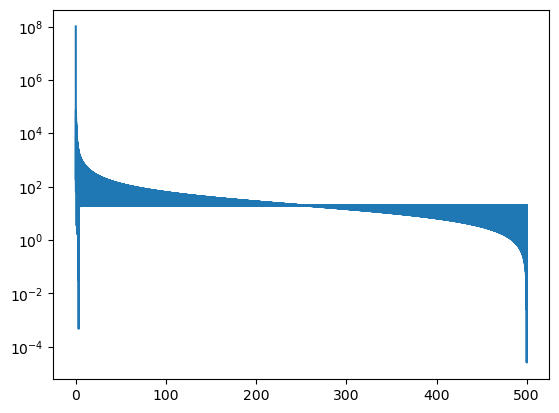

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

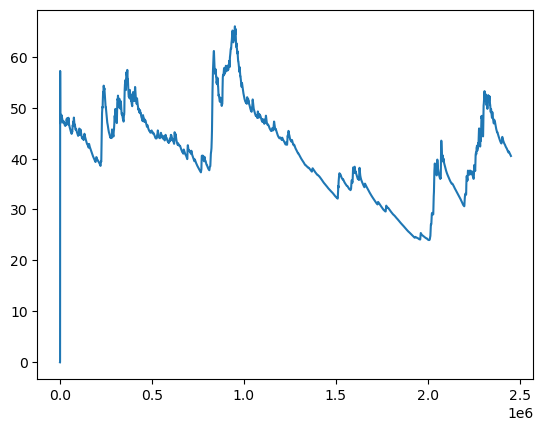

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  40.504
2451580  40.504
2451581  40.503
2451582  40.503
2451583  40.503

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

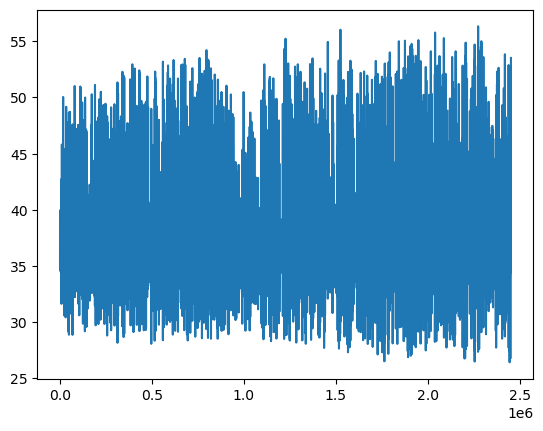

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

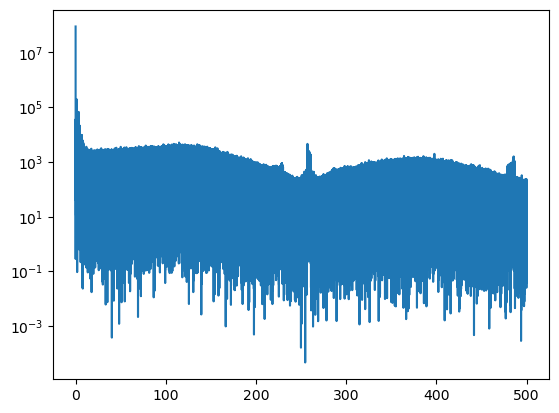

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

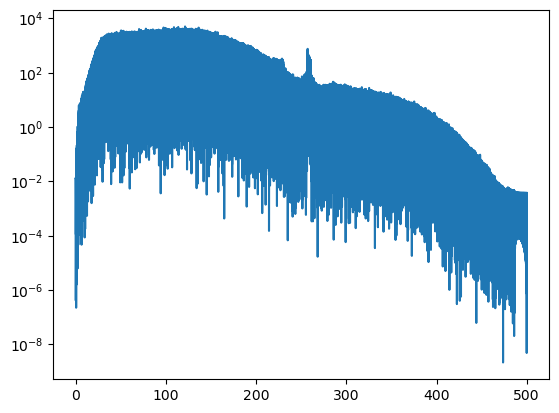

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

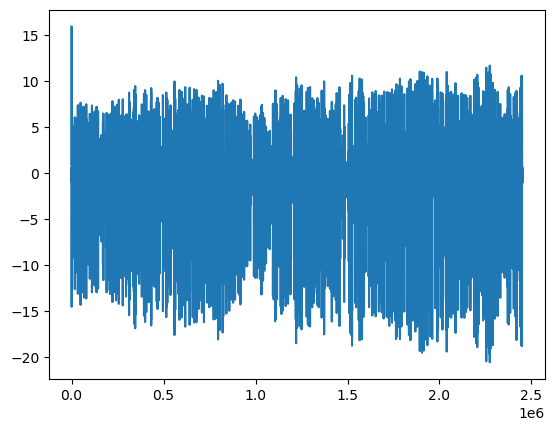

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        37.981
1        42.474
2        49.890
3        52.969
4        45.989
...         ...
2451579  36.994
2451580  36.993
2451581  36.993
2451582  36.993
2451583  36.993

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

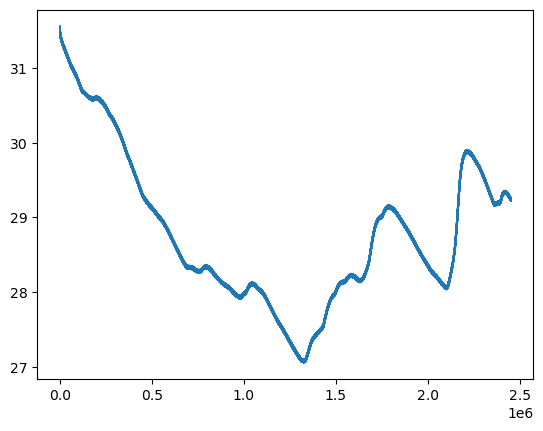

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

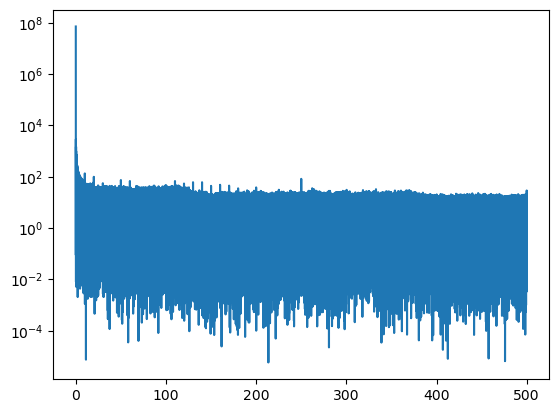

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

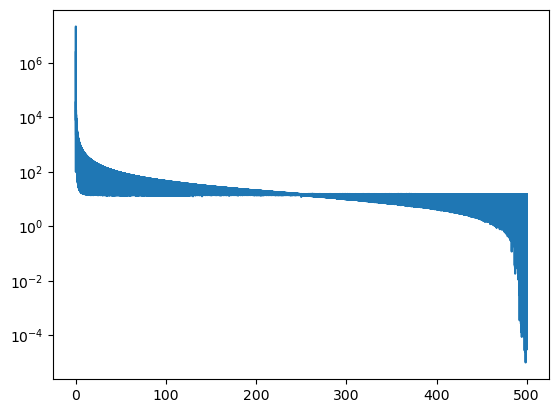

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

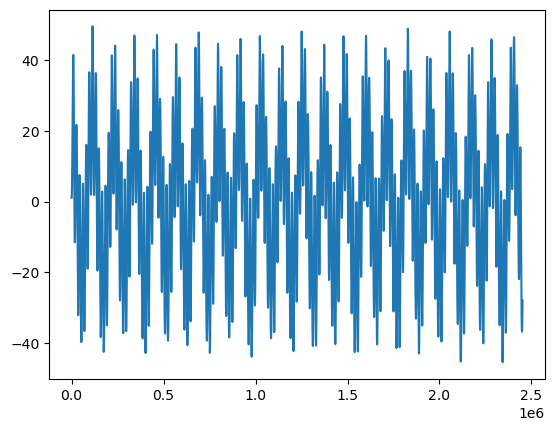

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        41.011
1        41.011
2        41.011
3        41.011
4        41.011
...         ...
2451579  11.979
2451580  11.984
2451581  11.989
2451582  11.994
2451583  11.999

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.941  48.014     7.329     8.603     7.945     10
1              1  0.941  48.024     7.329     8.562     7.945     10
2              2  0.941  48.034     7.329     8.521     7.945     10
3              3  0.941  48.043     7.329     8.479     7.945     10
4              4  0.948  48.072     7.410     8.682     8.108     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.732  46.020     4.988     8.925     6.056     12
2451580  2451580  0.728  46.020     4.988     8.966     6.056     12
2451581  2451581  0.725  46.020     4.988     9.007     6.056     12
2451582  2451582  0.722  46.020     4.988     9.048     6.056     12
2451583  2451583  0.718  46.020     4.988     9.089     6.056     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.941  48.014     7.329     8.603     7.945     10  37.981   
1              1  0.941  48.024     7.329     8.562     7.945     10  42.474   
2              2  0.941  48.034     7.329     8.521     7.945     10  49.890   
3              3  0.941  48.043     7.329     8.479     7.945     10  52.969   
4              4  0.948  48.072     7.410     8.682     8.108     10  45.989   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.732  46.020     4.988     8.925     6.056     12  36.994   
2451580  2451580  0.728  46.020     4.988     8.966     6.056     12  36.993   
2451581  2451581  0.725  46.020     4.988     9.007     6.056     12  36.993   
2451582  2451582  0.722  46.020     4.988     9.048     6.056     12  36.993   
2451583  2451583  0.718  46.020     4.988     9.089     6.056     12  36.993   

            gsr     skt  
0         0.000  41.011  
1         0.000  41.011  
2         0.000  41.011  
3         0.000  41.011  
4         0.000  41.011  
...         ...     ...  
2451579  40.504  11.979  
2451580  40.504  11.984  
2451581  40.503  11.989  
2451582  40.503  11.994  
2451583  40.503  11.999  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.625000  0.640591  0.362504  0.783627  0.749838  0.005071   
221502    221502  0.634174  0.638795  0.362504  0.783550  0.752911  0.005204   
221503    221503  0.626720  0.638795  0.362527  0.783473  0.752911  0.005334   
221504    221504  0.626720  0.639631  0.362527  0.783396  0.755983  0.005338   
221505    221505  0.629014  0.638702  0.362551  0.783319  0.752911  0.005594   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.661124  0.635421  0.647193  0.337908  0.607374  0.035038   
2331580  2331580  0.662844  0.633873  0.647193  0.337985  0.612063  0.034775   
2331581  2331581  0.664564  0.635699  0.647170  0.338073  0.610446  0.034385   
2331582  2331582  0.653670  0.639260  0.647170  0.338150  0.604301  0.033865   
2331583  2331583  0.662844  0.640900  0.647170  0.338227  0.607374  0.033472   

         emg_coru  emg_trap  video  
221501   0.118030  0.055418      1  
221502   0.119872  0.052416      1  
221503   0.119872  0.052379      1  
221504   0.123512  0.052379      1  
221505   0.123557  0.053880      1  
...           ...       ...    ...  
2331579  0.049692  0.035419      8  
2331580  0.049737  0.035419      8  
2331581  0.049737  0.035419      8  
2331582  0.046098  0.035419      8  
2331583  0.046053  0.032380      8  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.625000  0.640591  0.362504  0.749838  0.783627  0.005071   
221502    221502  0.634174  0.638795  0.362504  0.752911  0.783550  0.005204   
221503    221503  0.626720  0.638795  0.362527  0.752911  0.783473  0.005334   
221504    221504  0.626720  0.639631  0.362527  0.755983  0.783396  0.005338   
221505    221505  0.629014  0.638702  0.362551  0.752911  0.783319  0.005594   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.661124  0.635421  0.647193  0.607374  0.337908  0.035038   
2331580  2331580  0.662844  0.633873  0.647193  0.612063  0.337985  0.034775   
2331581  2331581  0.664564  0.635699  0.647170  0.610446  0.338073  0.034385   
2331582  2331582  0.653670  0.639260  0.647170  0.604301  0.338150  0.033865   
2331583  2331583  0.662844  0.640900  0.647170  0.607374  0.338227  0.033472   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.643922  0.635699  0.362718  0.757600  0.782186  0.005594  0.132812   
221540   0.657110  0.637464  0.362956  0.757600  0.780656  0.004814  0.114346   
221560   0.660550  0.636226  0.363171  0.762290  0.779137  0.004684  0.129083   
221580   0.683486  0.638578  0.363385  0.766979  0.777619  0.004817  0.114301   
221600   0.711583  0.640622  0.363623  0.768596  0.776089  0.004684  0.142023   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.576261  0.645358  0.647360  0.591688  0.331371  0.045063  0.053421   
2331520  0.587156  0.639848  0.647312  0.593305  0.333022  0.028657  0.049782   
2331540  0.610092  0.638578  0.647265  0.602684  0.334683  0.032038  0.055308   
2331560  0.636468  0.639910  0.647217  0.602684  0.336334  0.043357  0.046053   
2331580  0.662844  0.633873  0.647193  0.612063  0.337985  0.034775  0.049737   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.643922  0.635699  0.362718  0.757600  0.782186  0.005594  0.132812   
1      0.657110  0.637464  0.362956  0.757600  0.780656  0.004814  0.114346   
2      0.660550  0.636226  0.363171  0.762290  0.779137  0.004684  0.129083   
3      0.683486  0.638578  0.363385  0.766979  0.777619  0.004817  0.114301   
4      0.711583  0.640622  0.363623  0.768596  0.776089  0.004684  0.142023   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.576261  0.645358  0.647360  0.591688  0.331371  0.045063  0.053421   
63500  0.587156  0.639848  0.647312  0.593305  0.333022  0.028657  0.049782   
63501  0.610092  0.638578  0.647265  0.602684  0.334683  0.032038  0.055308   
63502  0.636468  0.639910  0.647217  0.602684  0.336334  0.043357  0.046053   
63503  0.662844  0.633873  0.647193  0.612063  0.337985  0.034775  0.049737   

       emg_trap  valence  arousal  
0      0.047764    5.000    5.000  
1      0.043074    5.000    5.000  
2      0.036920    5.000    5.000  
3      0.041610    5.000    5.000  
4      0.038496    5.000    5.000  
...         ...      ...      ...  
63499  0.050878    2.889    5.934  
63500  0.044650    2.889    5.934  
63501  0.040035    2.889    5.934  
63502  0.035419    2.888    5.934  
63503  0.035419    2.889    5.934  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.643922  0.635699  0.362718  0.757600  0.782186  0.005594  0.132812   
1      0.657110  0.637464  0.362956  0.757600  0.780656  0.004814  0.114346   
2      0.660550  0.636226  0.363171  0.762290  0.779137  0.004684  0.129083   
3      0.683486  0.638578  0.363385  0.766979  0.777619  0.004817  0.114301   
4      0.711583  0.640622  0.363623  0.768596  0.776089  0.004684  0.142023   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.498853  0.636814  0.647551  0.571313  0.324724  0.050268  0.060835   
63496  0.545872  0.637340  0.647503  0.579075  0.326386  0.041949  0.049782   
63497  0.545872  0.638733  0.647455  0.574547  0.328047  0.026570  0.047985   
63498  0.563073  0.637093  0.647408  0.583765  0.329709  0.041023  0.057106   
63499  0.576261  0.645358  0.647360  0.591688  0.331371  0.045063  0.053421   

       emg_trap  valence  arousal  
0      0.047764    5.000    5.000  
1      0.043074    5.000    5.000  
2      0.036920    5.000    5.000  
3      0.041610    5.000    5.000  
4      0.038496    5.000    5.000  
...         ...      ...      ...  
63495  0.130947    2.889    5.934  
63496  0.093989    2.889    5.934  
63497  0.064761    2.889    5.934  
63498  0.063072    2.889    5.934  
63499  0.050878    2.889    5.934  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.643922  0.635699  0.362718  0.757600  0.782186  0.005594  0.132812   
 1   0.657110  0.637464  0.362956  0.757600  0.780656  0.004814  0.114346   
 2   0.660550  0.636226  0.363171  0.762290  0.779137  0.004684  0.129083   
 3   0.683486  0.638578  0.363385  0.766979  0.777619  0.004817  0.114301   
 4   0.711583  0.640622  0.363623  0.768596  0.776089  0.004684  0.142023   
 5   0.726491  0.639136  0.363838  0.770052  0.774549  0.004167  0.130925   
 6   0.745413  0.639507  0.364052  0.773286  0.773019  0.003904  0.129038   
 7   0.736239  0.638455  0.364243  0.766979  0.771478  0.003641  0.119917   
 8   0.687500  0.638052  0.364457  0.773286  0.769949  0.004814  0.121715   
 9   0.634174  0.639476  0.364672  0.773286  0.768408  0.004427  0.101451   
 10  0.606078  0.639352  0.364862  0.781048  0.766867  0.004814  0.116143   
 11  0.594610  0.640962  0.365053  0.777975  0.765327  0.004431  0.110617   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.643922  0.635699  0.362718  0.757600  0.782186  0.005594  0.132812   
1     0.570528  0.646937  0.367292  0.723157  0.743593  0.004684  0.119872   
2     0.715596  0.638207  0.369556  0.655886  0.704768  0.004424  0.084827   
3     0.532683  0.638083  0.369699  0.633894  0.667033  0.004424  0.097767   
4     0.589450  0.637897  0.368103  0.618208  0.631478  0.004944  0.060835   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.705849  0.639941  0.675331  0.630821  0.147253  0.016406  0.068248   
2536  0.572248  0.637278  0.669208  0.546248  0.177295  0.032682  0.097632   
2537  0.611812  0.639414  0.658653  0.505498  0.212103  0.028124  0.071932   
2538  0.497133  0.646380  0.650457  0.489974  0.250597  0.038812  0.064519   
2539  0.544151  0.653469  0.647670  0.489974  0.291435  0.032165  0.069911   

             8         9        10  ...       193       194       195  \
0     0.047764  0.657110  0.637464  ...  0.566514  0.640622  0.367150   
1     0.021574  0.588876  0.637897  ...  0.751147  0.637557  0.369508   
2     0.030842  0.655390  0.638207  ...  0.530963  0.635638  0.369770   
3     0.035419  0.534404  0.618611  ...  0.587156  0.639662  0.368150   
4     0.023075  0.591170  0.632356  ...  0.188073  0.636597  0.366530   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.029304  0.638188  0.637093  ...  0.587156  0.640405  0.669565   
2536  0.029154  0.585436  0.627867  ...  0.591170  0.638578  0.659082   
2537  0.050878  0.621560  0.639879  ...  0.538417  0.612234  0.650720   
2538  0.038496  0.489679  0.637495  ...  0.544151  0.628672  0.647694   
2539  0.029229  0.549885  0.633718  ...  0.576261  0.645358  0.647360   

           196       197       198       199       200  valence  arousal  
0     0.727846  0.745144  0.005071  0.121715  0.021574  5.00000  5.00000  
1     0.655886  0.706309  0.004554  0.101406  0.033881  5.00000  5.00000  
2     0.626132  0.668497  0.004161  0.090354  0.026189  5.00000  5.00000  
3     0.624515  0.632853  0.006378  0.079256  0.030767  5.00000  5.00000  
4     0.618370  0.600258  0.005074  0.077459  0.118603  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.540103  0.175997  0.028394  0.075707  0.020074  2.90600  5.85104  
2536  0.505660  0.210639  0.026041  0.079211  0.067687  2.90600  5.86028  
2537  0.485446  0.249001  0.056804  0.060835  0.024651  2.90100  5.89572  
2538  0.483829  0.289773  0.033069  0.058993  0.026227  2.88984  5.93120  
2539  0.591688  0.331371  0.045063  0.053421  0.050878  2.88900  5.93400  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.643922  0.635699  0.362718  0.757600  0.782186  0.005594  0.132812   
1     0.570528  0.646937  0.367292  0.723157  0.743593  0.004684  0.119872   
2     0.715596  0.638207  0.369556  0.655886  0.704768  0.004424  0.084827   
3     0.532683  0.638083  0.369699  0.633894  0.667033  0.004424  0.097767   
4     0.589450  0.637897  0.368103  0.618208  0.631478  0.004944  0.060835   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.705849  0.639941  0.675331  0.630821  0.147253  0.016406  0.068248   
2536  0.572248  0.637278  0.669208  0.546248  0.177295  0.032682  0.097632   
2537  0.611812  0.639414  0.658653  0.505498  0.212103  0.028124  0.071932   
2538  0.497133  0.646380  0.650457  0.489974  0.250597  0.038812  0.064519   
2539  0.544151  0.653469  0.647670  0.489974  0.291435  0.032165  0.069911   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub29.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.643922  0.635699  0.362718  0.757600  0.782186  0.005594  0.132812   
1     0.570528  0.646937  0.367292  0.723157  0.743593  0.004684  0.119872   
2     0.715596  0.638207  0.369556  0.655886  0.704768  0.004424  0.084827   
3     0.532683  0.638083  0.369699  0.633894  0.667033  0.004424  0.097767   
4     0.589450  0.637897  0.368103  0.618208  0.631478  0.004944  0.060835   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.705849  0.639941  0.675331  0.630821  0.147253  0.016406  0.068248   
2536  0.572248  0.637278  0.669208  0.546248  0.177295  0.032682  0.097632   
2537  0.611812  0.639414  0.658653  0.505498  0.212103  0.028124  0.071932   
2538  0.497133  0.646380  0.650457  0.489974  0.250597  0.038812  0.064519   
2539  0.544151  0.653469  0.647670  0.489974  0.291435  0.032165  0.069911   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub29.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.643922  0.635699  0.362718  0.757600  0.782186  0.005594  0.132812   
1     0.570528  0.646937  0.367292  0.723157  0.743593  0.004684  0.119872   
2     0.715596  0.638207  0.369556  0.655886  0.704768  0.004424  0.084827   
3     0.532683  0.638083  0.369699  0.633894  0.667033  0.004424  0.097767   
4     0.589450  0.637897  0.368103  0.618208  0.631478  0.004944  0.060835   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.705849  0.639941  0.675331  0.630821  0.147253  0.016406  0.068248   
2536  0.572248  0.637278  0.669208  0.546248  0.177295  0.032682  0.097632   
2537  0.611812  0.639414  0.658653  0.505498  0.212103  0.028124  0.071932   
2538  0.497133  0.646380  0.650457  0.489974  0.250597  0.038812  0.064519   
2539  0.544151  0.653469  0.647670  0.489974  0.291435  0.032165  0.069911   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub29.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.643922  0.635699  0.362718  0.757600  0.782186  0.005594  0.132812   
1     0.570528  0.646937  0.367292  0.723157  0.743593  0.004684  0.119872   
2     0.715596  0.638207  0.369556  0.655886  0.704768  0.004424  0.084827   
3     0.532683  0.638083  0.369699  0.633894  0.667033  0.004424  0.097767   
4     0.589450  0.637897  0.368103  0.618208  0.631478  0.004944  0.060835   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.705849  0.639941  0.675331  0.630821  0.147253  0.016406  0.068248   
2536  0.572248  0.637278  0.669208  0.546248  0.177295  0.032682  0.097632   
2537  0.611812  0.639414  0.658653  0.505498  0.212103  0.028124  0.071932   
2538  0.497133  0.646380  0.650457  0.489974  0.250597  0.038812  0.064519   
2539  0.544151  0.653469  0.647670  0.489974  0.291435  0.032165  0.069911   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub29.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.643922  0.635699  0.362718  0.757600  0.782186  0.005594  0.132812   
1     0.570528  0.646937  0.367292  0.723157  0.743593  0.004684  0.119872   
2     0.715596  0.638207  0.369556  0.655886  0.704768  0.004424  0.084827   
3     0.532683  0.638083  0.369699  0.633894  0.667033  0.004424  0.097767   
4     0.589450  0.637897  0.368103  0.618208  0.631478  0.004944  0.060835   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.705849  0.639941  0.675331  0.630821  0.147253  0.016406  0.068248   
2536  0.572248  0.637278  0.669208  0.546248  0.177295  0.032682  0.097632   
2537  0.611812  0.639414  0.658653  0.505498  0.212103  0.028124  0.071932   
2538  0.497133  0.646380  0.650457  0.489974  0.250597  0.038812  0.064519   
2539  0.544151  0.653469  0.647670  0.489974  0.291435  0.032165  0.069911   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub29.csv', index=False)